In [ ]:
!pip install pydrive
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install mat4py
!pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15077 sha256=66cee37f5e3d2e53391584eb28efc8c83a64125719cfeac8a83d497a305d44fe
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
#drive.mount('/content/drive')

#when running from HDT: uncomment this
import sys, os

root_path = '/content/drive/MyDrive/TU/Master/MEP/Paper/Working_file_copied_from_final_code/Experiment_3+2b'

#path_dir = os.getcwd()

sys.path.append(root_path+"/Functions")
#sys.path[0]=root_path+"/Functions"

from general_functions import *
from muscle_functions import *
from integrator_functions import *
from matrices_functions import * #can make specific later if bloated
from constants_functions import *
from plot_functions import *
from save_functions import *
#[64.63326279  9.20098643 -1.42254849  0.12849197]

In [ ]:
#pick a trajectory number from Flash experiments, recall optimal trajectory data and store in optimal_trajectory vector
traj_nr = 3
testref_traj1 = mat4py.loadmat('drive/My Drive/TU/Master/MEP/Paper/Working_file_copied_from_final_code/Experiment_3+2b/Optimal_trajectories/ref_traj3.mat')
optimal_trajectories = np.array(testref_traj1['ref_traj'])

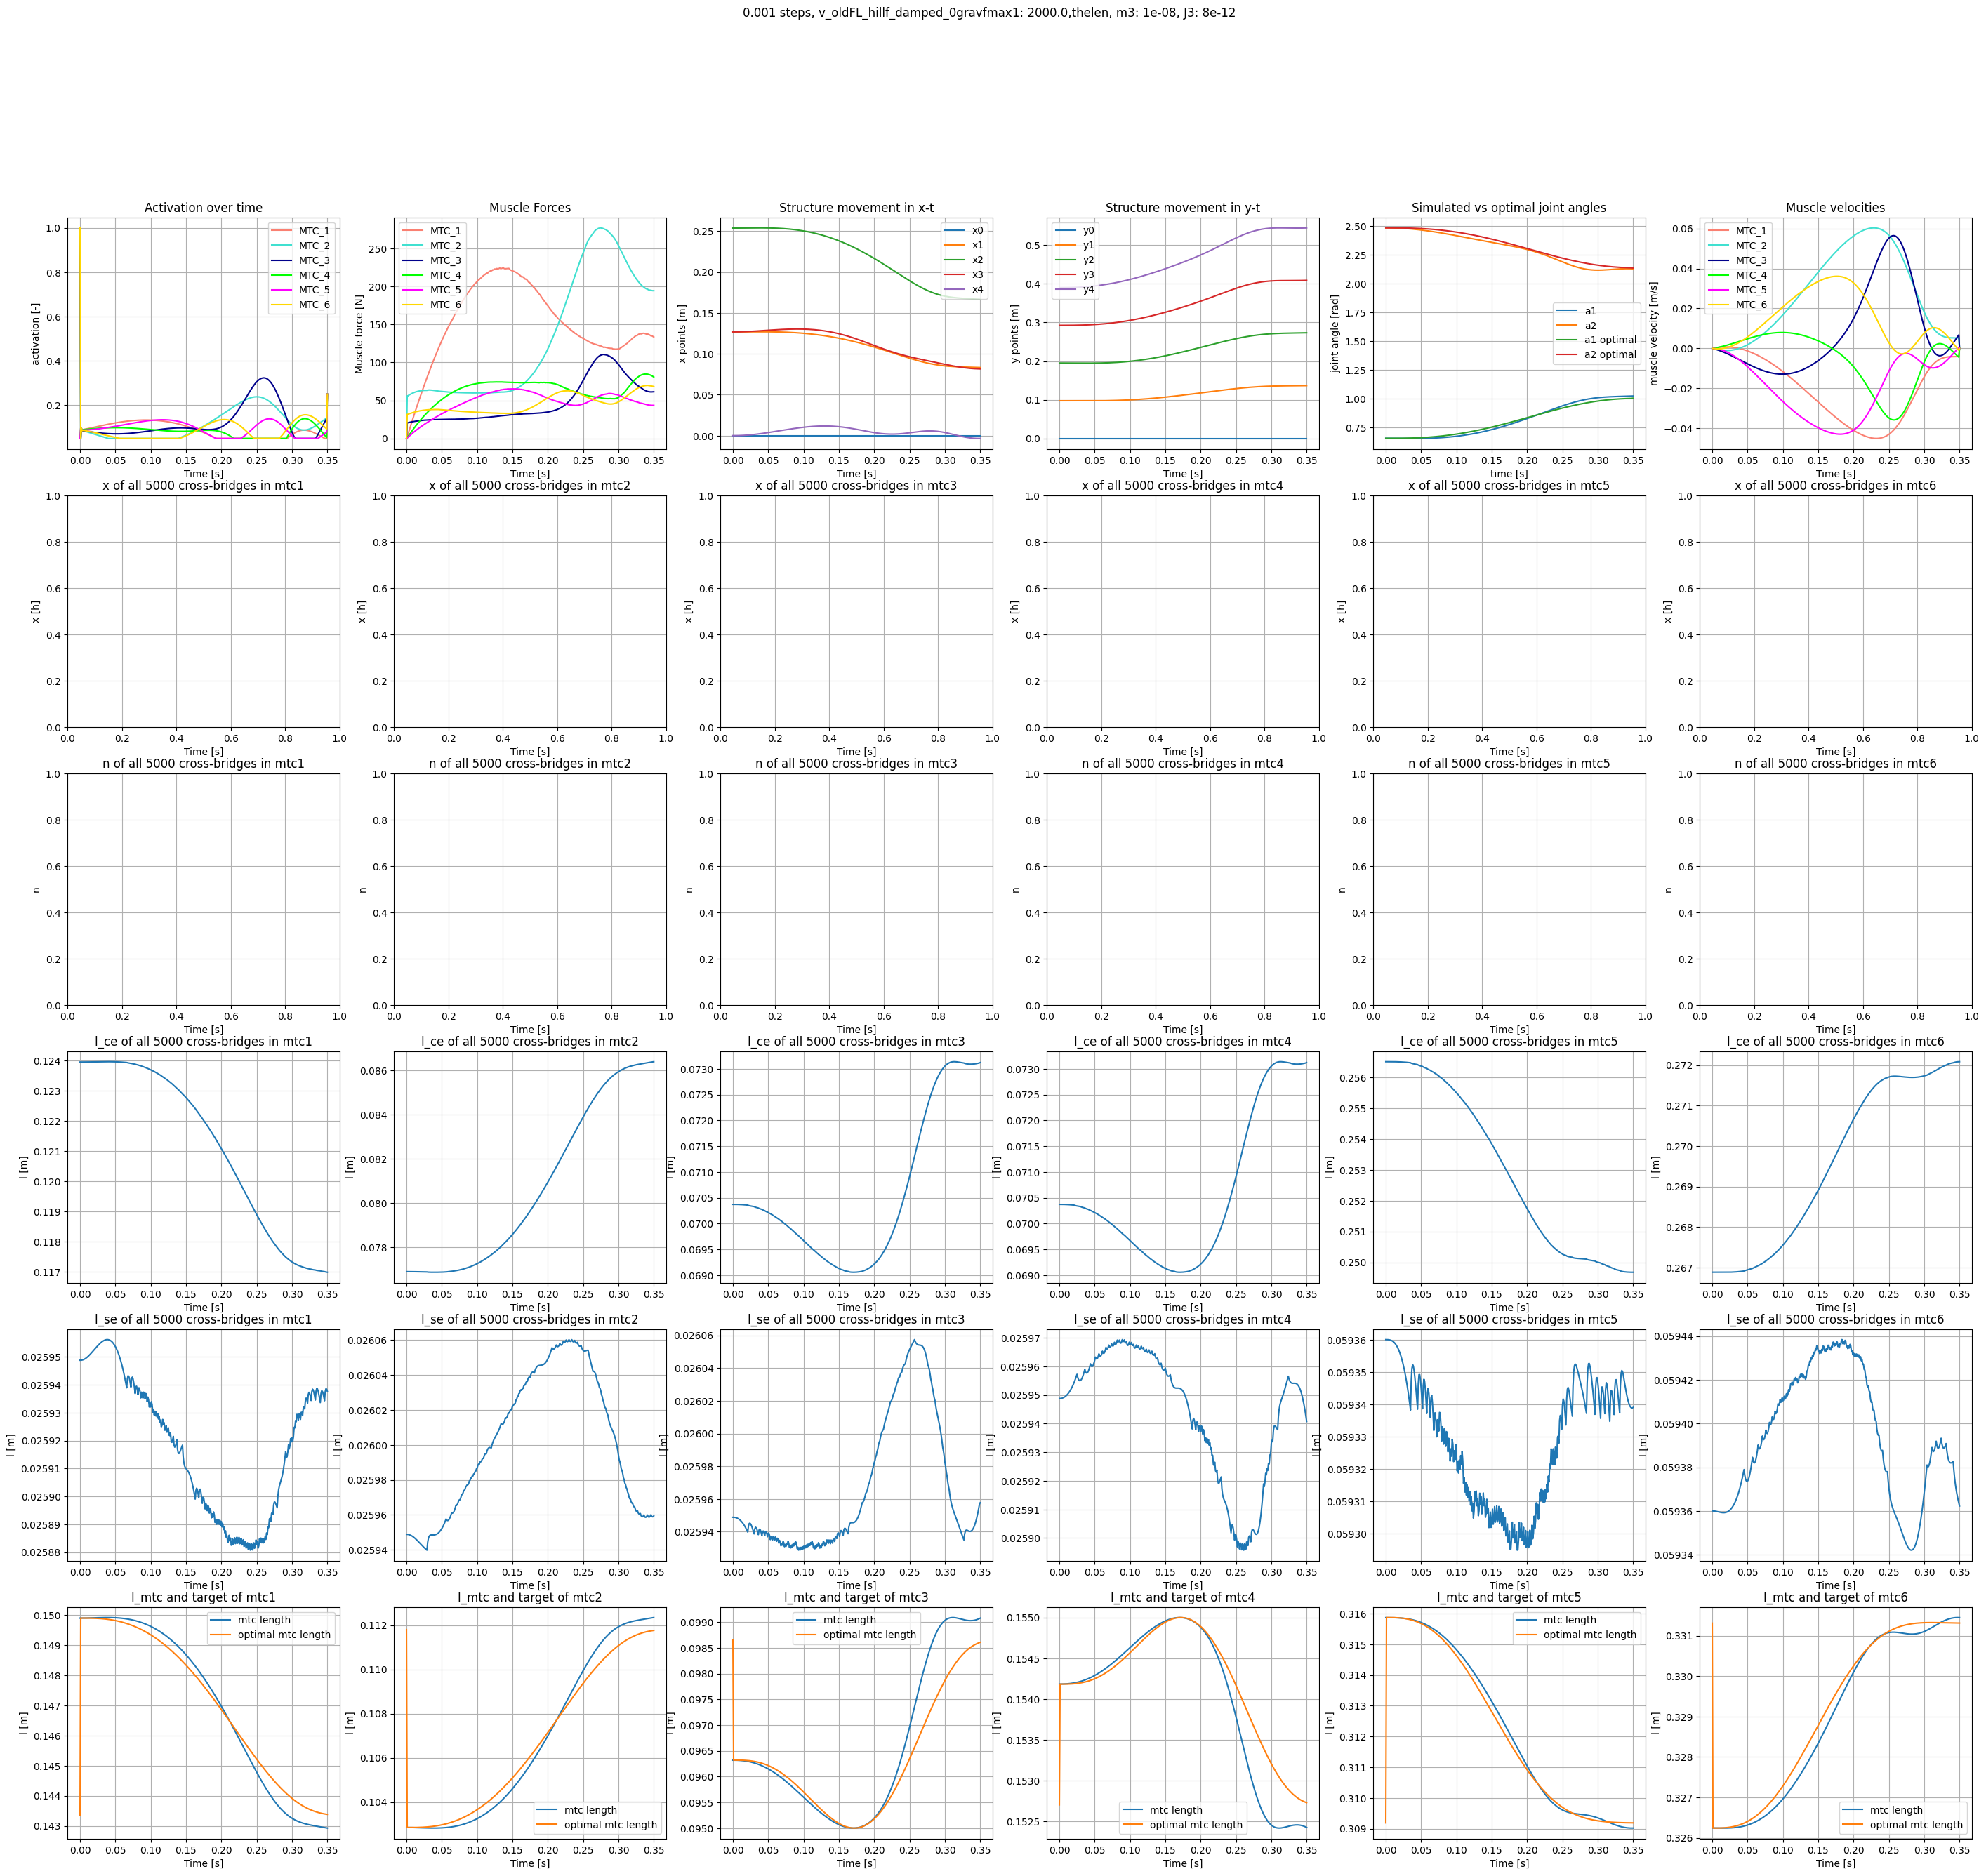

In [ ]:
opt_hill1_feedback_vector = [ 1.79588357e+02 , 1.48266795e+01, -9.51596047e-01 ,-2.74214174e-02]
opt_hux_feedback_vector =[99.25994797,  8.53835633 ,-1.24112202 , 0.10921817]
opt_stroeve_feedback_vector =  [90.08570008, -9.76164739, -1.6795049,   0.3007247 ]




feedback_vector = opt_hux_feedback_vector
#The stiffness region that the muscles start in must be in the experiment name. Names are:
#mostpos,verypos,newpos,newneg,mostneg for stiffness region 1-5. Region name must be preceded by stiff_start_
experiment_name = 'NEW_OKT_feedback_stiff_start_verypos_'

#protocol indicates the system configuration. 'straight_up_delay' for experiment 2 perturbation test, 'reaching' for experiment 3 robustness test
protocol = 'reaching'#'stroeve','straight_up','straight_up_delay','reaching'

save = True#If true, the experiment data will be saved to a dataset in /Results/data
Fmax_muscles = False  #keep False, this is set manually in the constants_functions function

#model type determines whether Huxley or Hill functions are used, v_type determines the used vce equation in the Huxley model (old is used) and FL_.. determines the used FL model (hill is used)
model_type,v_type,FL_type='huxley','v_old','FL_hill' #'huxley','hill'---'v_old','v_new'---'FL_0','FL_hill','FL_huxley'
hill_type = 'thijs'#determines the hill model used. 'thijs' for hill_expanded, 'stroeve' for hill_simple
f_type = 'f_damped_0grav'#determines how the force vector in matrices_functions.py is calculated. 'f_damped_fullgrav','f_damped__pgrav','f_damped__0grav','f_undamped_fullgrav','f_undamped__pgrav','f_undamped__0grav' ------------apply manually to matrices_functions.py
straight_og=False #If True, the current_muscle_starting_lengths will be defined with the arm in the straight up position
add_feedback = True #If True, the feedback system will be used to change the STIM parameter



#some experiment parameters
m3_value = 0.00000001       #allows for manual scaling of ball mass and inertia
f_factor = 1.0              #alllows for manual scaling of muscle force
t0 = 0.0                    #time start point (s)
tf = 0.35                   #time end point   (s)
t_stimulation = 0.01        #s at this time, the muscle stimulation will start
t_pertubation = False       #s at this time, the system perturbation will be applied. If False, no perturbation
h_step = 0.001              #stepsize         (s) #can not change, optimal lengths have the same size
muscle_number = 6           #nr of muscles used
tot_bridge_nr = 5000        #number of cross-bridges in the Huxley Model
step_nr = int((tf-t0)/h_step)
mus_vals = muscle_vals_func()


stim_multiplier = 0.25#stim_multiplier_list[multiplier_nr]


if model_type == 'huxley':
    model_name = 'huxley'
if model_type == 'hill':
    model_name = hill_type
if model_type == 'huxley':
    specific_save_name = str(model_type)+'_stim__mult'+str(feedback_vector[:])
if model_type == 'hill':
    specific_save_name = str(model_type)+'_'+str(hill_type)+'_stim__mult'+str(feedback_vector[:])
if protocol == 'straight_up':
    starting_a1 = 0.5*sm.pi
if protocol == 'straight_up_delay':
    starting_a1 = 0.5*sm.pi
if protocol == 'stroeve':
    starting_a1 = 0.2*sm.pi
if protocol == 'reaching':
    starting_a1 = 0.5*sm.pi


l1, l2,l3,l4,m1, m2, J1, J2,F_mtc1,F_mtc2,F_mtc3,F_mtc4,F_mtc5,F_mtc6,r1,r2,B1,B2,thetar1,thetar2,PE_sh1,PE_sh2,PE_xm1,PE_xm2,T_max1,T_max2 = sm.symbols('l_1,l_2,l_3,l_4, m_1, m_2, J_1, J_2, F_{mtc_1},F_{mtc_2},F_{mtc_3},F_{mtc_4},F_{mtc_5},F_{mtc_6},r_1,r_2,B_1,B_2,theta_{r1},theta_{r2},PE_{sh1},PE_{sh2},PE_{xm1},PE_{xm2},T_{max1},T_{max2}')
t = sm.symbols('t')
alpha1 = sm.Function('alpha1')(t)
alpha2 = sm.Function('alpha2')(t)
alpha3 = sm.Function('alpha3')(t)
J3, m3 = sm.symbols('J_3,m_3')

#The joint locations and body center of masses are defined
x0=0
y0=0
x1=0.5*l1*(sm.cos(alpha1))
y1=0.5*l1*(sm.sin(alpha1))
x2=2*x1
y2=2*y1
x3=x2+0.5*l2*(sm.cos(alpha2))#alpha1 +
y3=y2+0.5*l2*(sm.sin(alpha2))#alpha1 +
x4=x2+l2*(sm.cos(alpha2))#alpha1 +
y4=y2+l2*(sm.sin(alpha2))#alpha1 +

#Here the starting and ending locations of the muscles are defined, which are later included in the state vector
#this makes the starts and endings of the muscles scale directly with the joint angle
#start is defined as the lowest point in the original stroeve image
xm1_start=-sm.sin(starting_a1)*r1 #-sm.sin(alpha1)*r1
ym1_start=sm.cos(starting_a1)*r1  #sm.cos(alpha1)*r1
xm1_end  =x2*l3/l1
ym1_end  =y2*l3/l1
xm2_start=sm.sin(starting_a1)*r1#sm.sin(alpha1)*r1
ym2_start=-sm.cos(starting_a1)*r1#-sm.cos(alpha1)*r1
xm2_end  =x2*l3/l1
ym2_end  =y2*l3/l1
xm3_start=x2*(l1-l4)/l1
ym3_start=y2*(l1-l4)/l1
xm3_end  =x2-sm.sin(alpha2)*r1#alpha1 +
ym3_end  =y2+sm.cos(alpha2)*r1#alpha1 +
xm4_start=x2*(l1-l4)/l1
ym4_start=y2*(l1-l4)/l1
xm4_end  =x2+sm.sin(alpha2)*r1#alpha1 +
ym4_end  =y2-sm.cos(alpha2)*r1#alpha1 +
xm5_start=-sm.sin(starting_a1)*r1
ym5_start=sm.cos(starting_a1)*r1
xm5_end  =xm3_end
ym5_end  =ym3_end
xm6_start=sm.sin(starting_a1)*r1
ym6_start=-sm.cos(starting_a1)*r1
xm6_end  =xm4_end
ym6_end  =ym4_end

#I might need to redefine these to simply increase or decrease the length in a pulley-like fashion
l_mtc1=sm.sqrt((xm1_end-xm1_start)**2+(ym1_end-ym1_start)**2)
l_mtc2=sm.sqrt((xm2_end-xm2_start)**2+(ym2_end-ym2_start)**2)
l_mtc3=sm.sqrt((xm3_end-xm3_start)**2+(ym3_end-ym3_start)**2)
l_mtc4=sm.sqrt((xm4_end-xm4_start)**2+(ym4_end-ym4_start)**2)
l_mtc5=sm.sqrt((xm5_end-xm5_start)**2+(ym5_end-ym5_start)**2)
l_mtc6=sm.sqrt((xm6_end-xm6_start)**2+(ym6_end-ym6_start)**2)

x = sm.Matrix([alpha1, x1, y1,alpha2,x3,y3,alpha3,x4,y4])
q = sm.Matrix([alpha1,alpha2,alpha3])
T_mat = x.diff(t).jacobian(q.diff(t))

#define constants and specifieds
p_protocol_stroeve = {
    l1: 0.32,    # m
    l2: 0.32,  # m
    l3: 0.125,  # m
    l4: 0.125,    #m
    m1: 1.8,    # kg
    J1: 0.015,    # kg*m^2 https://aip-scitation-org.tudelft.idm.oclc.org/doi/pdf/10.1063/1.3479844#:~:text=We%20can%20see%20that%20the,0.1kgm2%20to%200.5kgm2.
    m2: 1.6,    # m
    J2: 0.013,    # kg*m^2
    r1: 0.03,   #rad
    r2: 0.03,   #rad
    m3: 0.00000001,
    J3: 0.0000001, #ball: 2/5*M*r2. Say r of 0.05m, m of 2: 0.002
    B1: 0.3,#Shoulder damping, Nms/rad
    B2: 0.2,#Elbow damping, Nms/rad
    thetar1: 0.2*np.pi,#Shoulder rest angle, rad np.pi/3 OG
    thetar2: 0.2*np.pi,#Elbow rest angle, rad np.pi/2 OG
    PE_sh1: 18,#Shoulder PE shape
    PE_sh2: 18,#Elbow PE shape
    PE_xm1: 0.5*np.pi,#Shoulder PE range, rad
    PE_xm2: 0.5*np.pi,#Elbow PE range, rad
    T_max1: 75,#maximum shoulder torque, winters and stark 85
    T_max2: 51,#maximum elbow torque, winters and stark 85
}

p_protocol_straight_up = {
    l1: 0.32,    # m
    l2: 0.32,  # m
    l3: 0.125,  # m
    l4: 0.125,    #m
    m1: 1.8,    # kg
    J1: 0.015,    # kg*m^2 https://aip-scitation-org.tudelft.idm.oclc.org/doi/pdf/10.1063/1.3479844#:~:text=We%20can%20see%20that%20the,0.1kgm2%20to%200.5kgm2.
    m2: 1.6,    # m
    J2: 0.013,    # kg*m^2
    r1: 0.03,   #rad
    r2: 0.03,   #rad
    m3: m3_value,#0.00000001,#
    J3: 0.0008*m3_value, #ball: 2/5*M*r^2. Say r of 0.04m, m of 1: 0.00064. Circle: 0.5*m*r^2v #0.00000001,
    B1: 0.3,#Shoulder damping, Nms/rad
    B2: 0.2,#Elbow damping, Nms/rad
    thetar1: 1/3*np.pi,#Shoulder rest angle, rad
    thetar2: 0.5*np.pi,#Elbow rest angle, rad
    PE_sh1: 18,#Shoulder PE shape
    PE_sh2: 18,#Elbow PE shape
    PE_xm1: 0.5*np.pi,#Shoulder PE range, rad
    PE_xm2: 0.5*np.pi,#Elbow PE range, rad
    T_max1: 75,#maximum shoulder torque, winters and stark 85
    T_max2: 51,#maximum elbow torque, winters and stark 85
}
#initial conditions
init_protocol_stroeve = {
    alpha1: 0.2*np.pi,
    alpha2: 0.2*np.pi,
    alpha3: 0.0*np.pi,
    alpha1.diff(t): 0,
    alpha2.diff(t): 0,
    alpha3.diff(t): 0,
}
init_protocol_straight_up = {
    alpha1: 0.500000*np.pi,
    alpha2: 0.50000*np.pi,
    alpha3: 0.0*np.pi,
    alpha1.diff(t): 0,
    alpha2.diff(t): 0.001*np.pi,
    alpha3.diff(t): 0,
}
init_protocol_straight_up_delay = {
    alpha1: 0.50*np.pi,
    alpha2: 0.50*np.pi,
    alpha3: 0.0*np.pi,
    alpha1.diff(t): 0.0*np.pi,
    alpha2.diff(t): 0.0*np.pi,
    alpha3.diff(t): 0.0*np.pi,
}
init_protocol_reaching = {
    alpha1: 0.2086*np.pi,
    alpha2: 0.7914*np.pi,
    alpha3: 0.0000000001*np.pi,
    alpha1.diff(t): 0.0*np.pi,
    alpha2.diff(t): 0.0*np.pi,
    alpha3.diff(t): 0.0*np.pi,
}
pert_protocol_straight_up_delay = {
    alpha1: 0.0*np.pi,
    alpha2: 0.0*np.pi,
    alpha3: 0.0*np.pi,
    alpha1.diff(t): 0.0*np.pi,
    alpha2.diff(t): 0.005*np.pi,
    alpha3.diff(t): 0.0*np.pi,
}

if protocol == 'straight_up':
    init = init_protocol_straight_up
    p = p_protocol_straight_up
    t_pertubation = False
    pert_vals = False
if protocol == 'stroeve':
    init = init_protocol_stroeve
    p = p_protocol_stroeve
    pert_vals = False
if protocol == 'straight_up_delay':
    init = init_protocol_straight_up_delay
    p = p_protocol_straight_up
    pert_vals = np.array(list(pert_protocol_straight_up_delay.values()))
if protocol == 'reaching':
    init = init_protocol_reaching
    p = p_protocol_straight_up
    t_pertubation = False
    pert_vals = False

r = {
    F_mtc1:   0.000000001,  # N
    F_mtc2:   0.000000001,  # N
    F_mtc3:   0.000000001,  # N
    F_mtc4:   0.000000001,  # N
    F_mtc5:   0.000000001,  # N
    F_mtc6:   0.000000001,  # N
}

#invoke system calculation functions
F_newton, M_newton, q_args, qd_args, p_args, r_args = F_M_vars_calc(l1, l2,l3,l4,m1, m2, J1, J2,F_mtc1,F_mtc2,F_mtc3,F_mtc4,F_mtc5,F_mtc6,r1,r2,t,alpha1,alpha2,x0,x1,x2,x3,x4,y0,y1,y2,y3,y4,p,r,J3,m3,alpha3,B1,B2,thetar1,thetar2,PE_sh1,PE_sh2,PE_xm1,PE_xm2,T_max1,T_max2,f_type);
M_tmt, Q_tmt, C_M, C_Q, A, b, eval_A, eval_b, eval_C, eval_Cd, eval_Cq, g_conv = matrices_func(M_newton, F_newton, q_args, qd_args, p_args, r_args, T_mat,x,q,t);
init_vals = np.array(list(init.values()))

#Make arrays of the values in order for use in the numerical functions
q_vals = np.array([init_vals[0],init_vals[1],init_vals[2]])
qd_vals = np.array([init_vals[3], init_vals[4], init_vals[5]])
p_vals = np.array([p[p_sym] for p_sym in p_args])
r_vals = np.array([r[r_sym] for r_sym in r_args])
eval_xs = sm.lambdify((q_args, p_args), [x0,x0,x1,x2,x3,x4])
eval_ys = sm.lambdify((q_args, p_args), [y0,y0,y1,y2,y3,y4])
eval_ls = sm.lambdify((q_args, p_args), [l_mtc1, l_mtc2,l_mtc3,l_mtc4,l_mtc5,l_mtc6])

#make an input stimulation vector
step_nr = int((tf-t0)/h_step)
input_STIM = [[]]*muscle_number
starting_step = int((t_stimulation/tf)*step_nr)
input_STIM[0] = np.ones(step_nr+2)*stim_multiplier*1
input_STIM[1] = np.ones(step_nr+2)*stim_multiplier*1
input_STIM[2] = np.ones(step_nr+2)*stim_multiplier*1
input_STIM[3] = np.ones(step_nr+2)*stim_multiplier*1
input_STIM[4] = np.ones(step_nr+2)*stim_multiplier*1
input_STIM[5] = np.ones(step_nr+2)*stim_multiplier*1
input_STIM[0][0:starting_step] = 0 #this way, step input should be applied at 0.01 s
input_STIM[1][0:starting_step] = 0
input_STIM[2][0:starting_step] = 0
input_STIM[3][0:starting_step] = 0
input_STIM[4][0:starting_step] = 0
input_STIM[5][0:starting_step] = 0

#create function to iterate over with rk4
eval_rhs2 = lambda t, s, r_vals: eval_rhs(t, s, p_vals, r_vals,eval_A, eval_b)[0]  # don't output the Lagrange multipliers

for kkk in range(muscle_number):#scale the maximum force variables
    mus_vals[kkk][7]*=f_factor

#execute calculations
t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,activation,mus_vals_changed,K_SE_list,K_CE_list,force_vector = rk4_integrator(eval_rhs2, t0, tf, init_vals, t_pertubation,pert_vals,h_step, r_vals, muscle_number, tot_bridge_nr, eval_xs, eval_ys, eval_ls,p_vals,mus_vals,Fmax_muscles,f_factor,False,True,input_STIM,True,False,model_type,hill_type,v_type,FL_type,straight_og,specific_save_name,experiment_name,optimal_trajectories,feedback_vector,add_feedback)

#some data preparation
l_mtcs = [[]]*muscle_number
for muscle in range(muscle_number):
    l_mtcs[muscle] = coords_vals[:,2][:,muscle]
if model_type =='huxley':
    lCEs = np.zeros((muscle_number,len(states[0][:,-2])))
    lSEs = np.zeros((muscle_number,len(states[0][:,-2])))
    for i in range(muscle_number):
        lCEs[i] = states[i][:,-2]
    for i in range(muscle_number):
        lSEs[i] = coords_vals[:,2,i] - lCEs[i]
if model_type =='hill':
    if hill_type == 'stroeve':
        lCEs = np.zeros((muscle_number,len(states[0])))
        vCEs = np.zeros((muscle_number,len(states[0])))
        for muscle in range(muscle_number):
            lCEs[muscle] = l_mtcs[muscle] - 0.02
            vCEs[muscle] = np.gradient(lCEs[muscle],h_step)
    if hill_type == 'thijs':
        lCEs = np.zeros((muscle_number,len(states[0])))
        vCEs = np.zeros((muscle_number,len(states[0])))
        for muscle in range(muscle_number):
            lCEs[muscle] = states[muscle][:,0]
            vCEs[muscle] = force_vector[muscle][:,7]
optimal_muscle_length_array = np.zeros((len(t_vals),muscle_number))
for a in range(len(t_vals)):
    if a <=750: #length of optimal value vector
        optimal_muscle_length_array[a] = eval_ls([optimal_trajectories[:,1][a-1],optimal_trajectories[:,2][a-1]+optimal_trajectories[:,1][a-1],0],p_vals)#determine optimal muscle lengths at this time
    if a >750: #length of optimal value vector
        optimal_muscle_length_array[a] = eval_ls([optimal_trajectories[:,1][750],optimal_trajectories[:,2][750]+optimal_trajectories[:,1][750],0],p_vals)#determine optimal muscle lengths at this time

            #save data
if save == True:
    if model_type =='huxley':
        save_huxley(l_mtcs,tot_bridge_nr,states,force_vector,mtc_vels,input_STIM,lCEs,lSEs,K_CE_list,K_SE_list,coords_vals,s_vals,t_vals,experiment_name, specific_save_name)
    if model_type =='hill':
        save_hill(l_mtcs,calculated_muscle_forces,force_vector,mtc_vels,input_STIM,lCEs,vCEs,t_vals,s_vals,experiment_name,specific_save_name)


if model_type =='huuxley':
    plot_huxley_single_muscle(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,input_STIM,t0,tf,t_pertubation,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals_changed,np.array(list(p.values())),v_type,FL_type,f_type,K_SE_list,K_CE_list,lCEs,lSEs,save,experiment_name,specific_save_name)


#plot data
if model_type =='huxley':
    plot_huxley_full(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,input_STIM,t0,tf,t_pertubation,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals_changed,np.array(list(p.values())),v_type,FL_type,f_type,K_SE_list,K_CE_list,lCEs,lSEs,save,experiment_name,specific_save_name,optimal_trajectories,optimal_muscle_length_array)
if model_type == 'hill':
    plot_hill_full(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,input_STIM,t0,tf,t_pertubation,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals,save,experiment_name,specific_save_name,optimal_trajectories,optimal_muscle_length_array)




In [ ]:
'''
#animate

def plot_points(s):
    xs = eval_xs(s[:3], p_vals)
    ys = eval_ys(s[:3], p_vals)
    return xs, ys
#animation test
fig, ax = plt.subplots(figsize=(6, 6),
                       subplot_kw={'autoscale_on': True})
#ax.set_aspect('equal')
ax.grid()

#ax.axhline(p[yD], linestyle="--", color="C1")
line, = ax.plot([], [], 'o-', lw=2)
#ax.plot(p[xE], p[yE], 'o', markersize=8, color="C1")
time_template = 'time = %.1fs'
time_text = ax.text(0.8, 0.1, '', transform=ax.transAxes)
fps = 60
num_frames = tf*fps
divisor = int(len(t_vals)/num_frames)

def animate(i):
    x_plot, y_plot = plot_points(s_vals[1::divisor][i])
    line.set_data(x_plot, y_plot)
    time_text.set_text(time_template % (t_vals[1::divisor][i]))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, len(t_vals[1::divisor]), blit=True)

display(HTML(ani.to_jshtml(fps=fps)))
'''

'\n#animate\n\ndef plot_points(s):\n    xs = eval_xs(s[:3], p_vals)\n    ys = eval_ys(s[:3], p_vals)\n    return xs, ys\n#animation test\nfig, ax = plt.subplots(figsize=(6, 6),\n                       subplot_kw={\'autoscale_on\': True})\n#ax.set_aspect(\'equal\')\nax.grid()\n\n#ax.axhline(p[yD], linestyle="--", color="C1")\nline, = ax.plot([], [], \'o-\', lw=2)\n#ax.plot(p[xE], p[yE], \'o\', markersize=8, color="C1")\ntime_template = \'time = %.1fs\'\ntime_text = ax.text(0.8, 0.1, \'\', transform=ax.transAxes)\nfps = 60\nnum_frames = tf*fps\ndivisor = int(len(t_vals)/num_frames)\n\ndef animate(i):\n    x_plot, y_plot = plot_points(s_vals[1::divisor][i])\n    line.set_data(x_plot, y_plot)\n    time_text.set_text(time_template % (t_vals[1::divisor][i]))\n    return line, time_text\n\nani = animation.FuncAnimation(fig, animate, len(t_vals[1::divisor]), blit=True)\n\ndisplay(HTML(ani.to_jshtml(fps=fps)))\n'

3

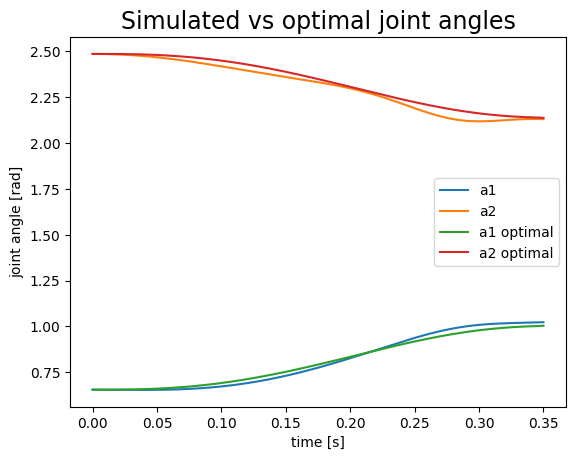

In [ ]:
opt_a1 = np.ones(len(t_vals))*optimal_trajectories[-1,1]
opt_a2 = np.ones(len(t_vals))*(optimal_trajectories[-1,2]+optimal_trajectories[-1,1])
if int(tf/h_step) > len(optimal_trajectories[:,1]):
    opt_a1[:len(optimal_trajectories[:,1])] = optimal_trajectories[:,1]
    opt_a2[:len(optimal_trajectories[:,2])] = optimal_trajectories[:,2]+optimal_trajectories[:,1]
if int(tf/h_step) <= len(optimal_trajectories[:,1]):
    opt_a1[:int(tf/h_step)] = optimal_trajectories[:int(tf/h_step),1]
    opt_a2[:int(tf/h_step)] = optimal_trajectories[:int(tf/h_step),2]+optimal_trajectories[:int(tf/h_step),1]
plt.plot(t_vals,s_vals[:,0],label='a1')
plt.plot(t_vals,s_vals[:,1],label='a2')
plt.plot(t_vals,opt_a1,label='a1 optimal')
plt.plot(t_vals,opt_a2,label='a2 optimal')
plt.xlabel('time [s]')
plt.ylabel('joint angle [rad]')
plt.legend(loc='right')
plt.title('Simulated vs optimal joint angles',fontsize=17)
len(coords_vals[1])

Error: 0.014282354912386584


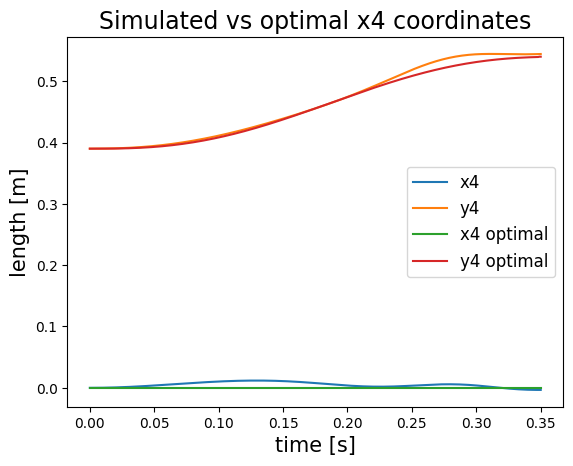

In [ ]:
opt_x = eval_xs([opt_a1,opt_a2,0],p_vals)#determine optimal muscle lengths at this time
opt_y = eval_ys([opt_a1,opt_a2,0],p_vals)
#print(opt_x)
#integrated_trajectory_error = np.trapz((s_vals[:,1]-opt_a2)**2)+2*np.trapz((s_vals[:,0]-opt_a1)**2)
integrated_trajectory_error = np.trapz((np.sqrt(opt_x[-1]**2+opt_y[-1]**2)-np.sqrt(coords_vals[:,1,-1]**2+coords_vals[:,0,-1]**2))**2)#np.trapz(np.sqrt(opt_x[-1]**2+opt_y[-1]**2)-np.sqrt(coords_vals[:,1,-1]**2+coords_vals[:,0,-1]**2))

plt.plot(t_vals,coords_vals[:,0,-1],label='x4')
plt.plot(t_vals,coords_vals[:,1,-1],label='y4')
plt.plot(t_vals,opt_x[-1],label='x4 optimal')
plt.plot(t_vals,opt_y[-1],label='y4 optimal')
plt.xlabel('time [s]',fontsize=15)
plt.ylabel('length [m]',fontsize=15)
plt.legend(loc='right',fontsize=12)
plt.title('Simulated vs optimal x4 coordinates',fontsize=17)
print('Error: '+str(integrated_trajectory_error))

Text(0.5, 1.0, 'Simulated vs optimal x4 coordinates')

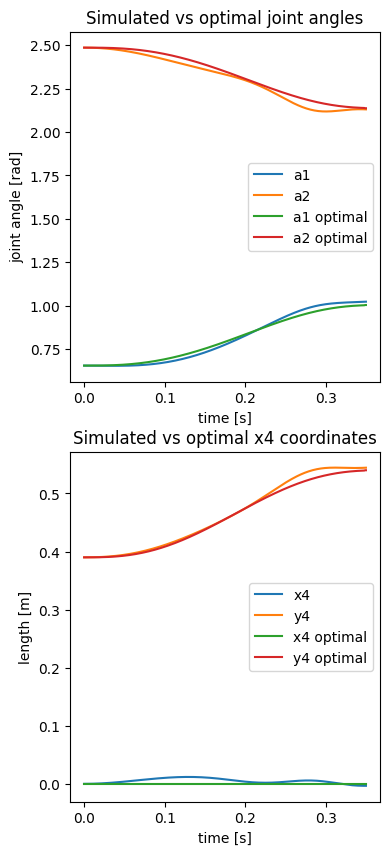

In [ ]:
fig, axes = plt.subplots(2,figsize=(4,10))

axes[0].plot(t_vals,s_vals[:,0],label='a1')
axes[0].plot(t_vals,s_vals[:,1],label='a2')
axes[0].plot(t_vals,opt_a1,label='a1 optimal')
axes[0].plot(t_vals,opt_a2,label='a2 optimal')
axes[0].set_xlabel('time [s]')
axes[0].set_ylabel('joint angle [rad]')
axes[0].legend(loc='right')
axes[0].set_title('Simulated vs optimal joint angles')
len(coords_vals[1])
opt_x = eval_xs([opt_a1,opt_a2,0],p_vals)#determine optimal muscle lengths at this time
opt_y = eval_ys([opt_a1,opt_a2,0],p_vals)
#print(opt_x)
#integrated_trajectory_error = np.trapz((s_vals[:,1]-opt_a2)**2)+2*np.trapz((s_vals[:,0]-opt_a1)**2)
integrated_trajectory_error = np.trapz((np.sqrt(opt_x[-1]**2+opt_y[-1]**2)-np.sqrt(coords_vals[:,1,-1]**2+coords_vals[:,0,-1]**2))**2)
axes[1].plot(t_vals,coords_vals[:,0,-1],label='x4')
axes[1].plot(t_vals,coords_vals[:,1,-1],label='y4')
axes[1].plot(t_vals,opt_x[-1],label='x4 optimal')
axes[1].plot(t_vals,opt_y[-1],label='y4 optimal')
axes[1].set_xlabel('time [s]')
axes[1].set_ylabel('length [m]')
axes[1].legend(loc='right')
axes[1].set_title('Simulated vs optimal x4 coordinates')
#fig.savefig('Results/sm_plot_'+str(experiment_name)+'__'+str(specific_save_name)+'.png')

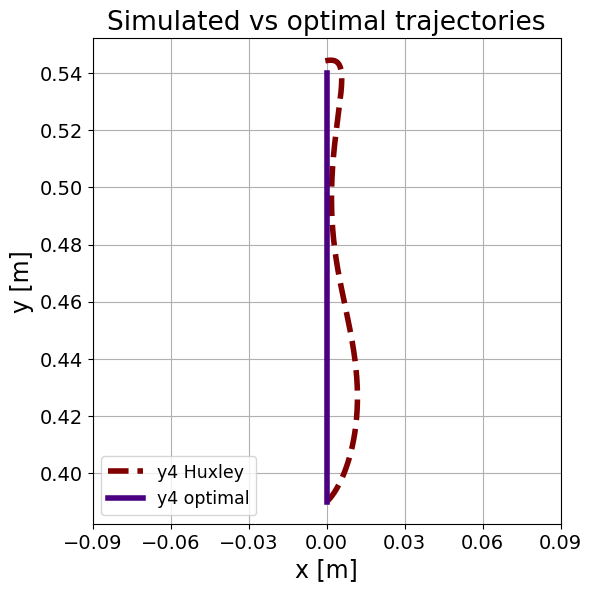

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(6,6))

#axes.plot(hill1opttrajs.sim_x4,hill1opttrajs.sim_y4,label='y4 Hill_expanded',color='cornflowerblue',linewidth =4,linestyle='dashdot')
axes.plot(coords_vals[:,0,-1],coords_vals[:,1,-1],label='y4 Huxley',color='maroon',linewidth =4,linestyle='--')
axes.plot(opt_x[-1],opt_y[-1],label='y4 optimal',color='indigo',linewidth =4)
axes.set_xlabel('x [m]',fontsize=17)
axes.set_ylabel('y [m]',fontsize=17)
axes.legend(loc='lower left',fontsize=12.5)
axes.set_title('Simulated vs optimal trajectories',fontsize=19)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_xticks(np.linspace(-0.09,0.09,7))
axes.grid()
axes.set_xlim([-0.09,0.09])
fig.tight_layout(pad=1.0)
#fig.savefig('drive/My Drive/TU/Master/MEP/Paper/Working_file_copied_from_final_code/Experiment_3+2b/Results/3a2_optimaltrajectories.png')

In [ ]:


optimaldata = xr.Dataset(
    data_vars=dict(
        optimal_a1 = (['time'],opt_a1),
        optimal_a2 = (['time'],opt_a2),
        optimal_x4 = (['time'],opt_x[-1]),
        optimal_y4 = (['time'],opt_y[-1]),
        sim_a1 = (['time'],s_vals[:,0]),
        sim_a2 = (['time'],s_vals[:,1]),
        sim_x4 = (['time'],coords_vals[:,0,-1]),
        sim_y4 = (['time'],coords_vals[:,1,-1]),
        optimal_feedback_vector = ('fb_nr',feedback_vector),
    ),
    coords=dict(
            time=(t_vals)
        ),
    attrs=dict(description="Integrated trajectory errors of simulated scaled optimal trajectories"),
    )

optimaldata.to_netcdf('drive/My Drive/TU/Master/MEP/Paper/Working_file_copied_from_final_code/Experiment_3+2b/Results/data/NEW_OKT_'+str(model_name)+'traj'+str(traj_nr)+'optimal_foundtrajectories')

In [ ]:
integrated_trajectory_error = np.trapz((np.sqrt(opt_x[-1]**2+opt_y[-1]**2)-np.sqrt(coords_vals[:,1,-1]**2+coords_vals[:,0,-1]**2))**2)
print(integrated_trajectory_error)

0.014282354912386584


In [ ]:
'''
def EE_Thelen_test(mus_vals,lSE,lPE,include_PE=False):#stiffness from matlab
    h_mtc,f1,g1,g2,g3,C1, C2, Fmax, lCEopt, s_mtc, K_SE, K_PE, K_CE, F_CEopt, width, t_act, t_deact, l_seslack, l_peslack, o_a_SE, o_a_PE, o_b_SE, o_b_PE,l_r,l_t,L_opt,L_sh,V_er,V_ml,V_vm,V_sh,V_shl, l_min, l_max, SE_sh,PE_sh,SE_Ftoe,SE_xm,PE_xm,A,epstoe,klin,h_mtc_og = mus_vals
    #SE_sh,PE_sh,SE_Ftoe,SE_xm,PE_xm = special_variables #SE_Ftoe = SE_SE_Ftoe
    l_seslack = 0.4
    #l_peslack = 1.3
    epsSE = (lSE - l_seslack)/l_seslack;
    epsPE = (lPE - l_peslack)/l_peslack;
    Kse = 'Dead'
    if epsSE<=epstoe:
        Kse = (1/l_seslack)*((SE_sh/epstoe)*Fmax*SE_Ftoe*np.exp(SE_sh*epsSE/epstoe)/(np.exp(SE_sh)-1))
    if epsSE>epstoe:
        Kse = (1/l_seslack)*Fmax*klin
    if Kse == 'Dead':
        print('Kse error')
        exit()
    Kpe = 0
    if include_PE==True:
        if epsPE>0:
            Kpe = (1/l_peslack)*Fmax*(PE_sh/PE_xm)*np.exp(PE_sh*epsPE/PE_xm)/(np.exp(PE_sh)-1);
    return Kse, Kpe
Ksetest, Kpetest=EE_Thelen_test(mus_vals_changed[0],0.409,0,include_PE=False)
print(Ksetest)
'''

"\ndef EE_Thelen_test(mus_vals,lSE,lPE,include_PE=False):#stiffness from matlab\n    h_mtc,f1,g1,g2,g3,C1, C2, Fmax, lCEopt, s_mtc, K_SE, K_PE, K_CE, F_CEopt, width, t_act, t_deact, l_seslack, l_peslack, o_a_SE, o_a_PE, o_b_SE, o_b_PE,l_r,l_t,L_opt,L_sh,V_er,V_ml,V_vm,V_sh,V_shl, l_min, l_max, SE_sh,PE_sh,SE_Ftoe,SE_xm,PE_xm,A,epstoe,klin,h_mtc_og = mus_vals\n    #SE_sh,PE_sh,SE_Ftoe,SE_xm,PE_xm = special_variables #SE_Ftoe = SE_SE_Ftoe\n    l_seslack = 0.4\n    #l_peslack = 1.3\n    epsSE = (lSE - l_seslack)/l_seslack;\n    epsPE = (lPE - l_peslack)/l_peslack;\n    Kse = 'Dead'\n    if epsSE<=epstoe:\n        Kse = (1/l_seslack)*((SE_sh/epstoe)*Fmax*SE_Ftoe*np.exp(SE_sh*epsSE/epstoe)/(np.exp(SE_sh)-1))\n    if epsSE>epstoe:\n        Kse = (1/l_seslack)*Fmax*klin\n    if Kse == 'Dead':\n        print('Kse error')\n        exit()\n    Kpe = 0\n    if include_PE==True:\n        if epsPE>0:\n            Kpe = (1/l_peslack)*Fmax*(PE_sh/PE_xm)*np.exp(PE_sh*epsPE/PE_xm)/(np.exp(PE_sh)-1);\n 

In [ ]:
aaaaa = [0,0]
if type(aaaaa) == bool:
    print('ok')



In [ ]:
len(s_vals[0])

6

In [ ]:
len(coords_vals[:,0,0])

351

In [ ]:
(np.array([3,3,3]) - np.array([1,1,1]))**2

array([4, 4, 4])

In [ ]:
coords_vals[:,1,-1]

array([0.39003255, 0.39003261, 0.39003393, 0.3900377 , 0.39004398,
       0.39005288, 0.39006449, 0.3900789 , 0.3900962 , 0.39011648,
       0.39013984, 0.39016636, 0.39019614, 0.39022926, 0.39026581,
       0.39030589, 0.39034958, 0.39039696, 0.39044812, 0.39050315,
       0.39056213, 0.39062514, 0.39069226, 0.39076357, 0.39083914,
       0.39091903, 0.39100332, 0.39109208, 0.39118538, 0.3912833 ,
       0.39138588, 0.39149322, 0.39160535, 0.39172235, 0.39184426,
       0.39197115, 0.39210306, 0.39224005, 0.39238214, 0.39252939,
       0.39268183, 0.39283951, 0.39300249, 0.39317083, 0.39334455,
       0.39352372, 0.39370837, 0.39389848, 0.39409408, 0.39429519,
       0.39450183, 0.39471406, 0.3949319 , 0.39515535, 0.39538441,
       0.39561911, 0.39585948, 0.39610554, 0.39635732, 0.39661479,
       0.39687797, 0.39714685, 0.39742145, 0.39770179, 0.39798788,
       0.39827972, 0.39857731, 0.39888065, 0.39918974, 0.39950455,
       0.3998251 , 0.40015137, 0.40048337, 0.40082107, 0.40116

array([0.39003255, 0.39003261, 0.39003393, 0.3900377 , 0.39004398,
       0.39005288, 0.39006449, 0.3900789 , 0.3900962 , 0.39011648,
       0.39013984, 0.39016636, 0.39019614, 0.39022926, 0.39026581,
       0.39030589, 0.39034958, 0.39039696, 0.39044812, 0.39050315,
       0.39056213, 0.39062514, 0.39069226, 0.39076357, 0.39083914,
       0.39091903, 0.39100332, 0.39109208, 0.39118538, 0.3912833 ,
       0.39138588, 0.39149322, 0.39160535, 0.39172235, 0.39184426,
       0.39197115, 0.39210306, 0.39224005, 0.39238214, 0.39252939,
       0.39268183, 0.39283951, 0.39300249, 0.39317083, 0.39334455,
       0.39352372, 0.39370837, 0.39389848, 0.39409408, 0.39429519,
       0.39450183, 0.39471406, 0.3949319 , 0.39515535, 0.39538441,
       0.39561911, 0.39585948, 0.39610554, 0.39635732, 0.39661479,
       0.39687797, 0.39714685, 0.39742145, 0.39770179, 0.39798788,
       0.39827972, 0.39857731, 0.39888065, 0.39918974, 0.39950455,
       0.3998251 , 0.40015137, 0.40048337, 0.40082107, 0.40116

In [ ]:
opt_a1 = np.ones(len(t_vals))*optimal_trajectories[-1,1]
opt_a2 = np.ones(len(t_vals))*(optimal_trajectories[-1,2]+optimal_trajectories[-1,1])
if int(tf/h_step) > len(optimal_trajectories[:,1]):
    opt_a1[:len(optimal_trajectories[:,1])] = optimal_trajectories[:,1]
    opt_a2[:len(optimal_trajectories[:,2])] = optimal_trajectories[:,2]+optimal_trajectories[:,1]
if int(tf/h_step) <= len(optimal_trajectories[:,1]):
    opt_a1[:int(tf/h_step)] = optimal_trajectories[:int(tf/h_step),1]
    opt_a2[:int(tf/h_step)] = optimal_trajectories[:int(tf/h_step),2]+optimal_trajectories[:int(tf/h_step),1]

opt_x=[[]]*len(opt_a1)
opt_y=[[]]*len(opt_a1)
opt_x = eval_xs([opt_a1,opt_a2,np.zeros(len(opt_a2))],p_vals)#determine optimal muscle lengths at this time
opt_y = eval_ys([opt_a1,opt_a2,0],p_vals)
print(opt_x[-1])

[ 5.55111512e-17  5.55111512e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.55111512e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.55111512e-17  0.00000000e+00
  5.55111512e-17  5.55111512e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.55111512e-17  5.55111512e-17  0.00000000e+00
  0.00000000e+00  5.55111512e-17  0.00000000e+00  5.55111512e-17
  0.00000000e+00  5.55111512e-17  5.55111512e-17  5.55111512e-17
  5.55111512e-17  5.55111512e-17  0.00000000e+00  0.00000000e+00
  5.55111512e-17  1.11022302e-16  5.55111512e-17  5.55111512e-17
  0.00000000e+00  1.11022302e-16  0.00000000e+00  0.00000000e+00
  5.55111512e-17  0.00000000e+00  0.00000000e+00  5.55111512e-17
  0.00000000e+00  5.55111512e-17  0.00000000e+00  5.55111512e-17
  0.00000000e+00  1.11022302e-16  0.00000000e+00  5.55111512e-17
  0.00000000e+00  0.00000000e+00  1.11022302e-16  1.11022302e-16
  0.00000000e+00  1.11022